# Introdução à Ciência de Dados - Trabalho Módulo 1

## Criando um dataset de carros usados coletados a partir da OLX

### Sumário

1. [Definição do problema](#Definição-do-problema)
2. [Extraindo as urls de cada página](#Extrair-as-urls-dos-carros-de-cada-página-da-OLX)
3. [Extraindo as informações de cada carro a partir das urls](#Extraindo-as-informações-de-cada-carro-a-partir-das-urls)
    - [Usando um único processo](#Single-Thread-Approach)
    - [Usando múltiplos processo (bem mais rápido)](#Single-Thread-Approach)
4. [Salvando o dataset]()
5. [Analises iniciais do dataset]()
6. [Filtrando amostras]()

## Definição do problema


lorem ipsum etc

In [4]:
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
import requests
import os
from tqdm import tqdm

In [ ]:
BASE_URL = 'https://www.olx.com.br/autos-e-pecas/carros-vans-e-utilitarios'
HEADERS = {
        'authority': 'olx.com.br',
        'method': 'GET',
        'scheme': 'https',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-site': 'same-origin',
        'sec-fetch-user': '?1',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)'
}

In [ ]:
def collect_links(n_pages=5):    
    total_pages = get_number_pages()
    
    if n_pages == 'all' or n_pages > total_pages:
        n_pages = total_pages

    for page in tqdm(range(n_pages)):
        url = f'{BASE_URL}?o={page+1}'
        response = requests.get(url=url, headers=HEADERS)
        
        soup = BeautifulSoup(response.content, 'lxml')
        items = soup.find_all('li', {'class': 'sc-1fcmfeb-2 juiJqh'})
        
        for item in items:
            try:
                with open('links.txt', 'a') as outfile:
                    outfile.write(item.findAll('a')[0]['href']+'\n')
            except IndexError:
                continue

In [ ]:
def get_number_pages():
    response = requests.get(url=BASE_URL, headers=HEADERS)
    soup = BeautifulSoup(response.content, 'lxml')
    results = soup.findAll('span', {'class': 'sc-1mi5vq6-0 eDXljX sc-ifAKCX fhJlIo'})

    ITEMS_PER_PAGE = 50
    n_cars_found = float(results[0].contents[0].split('de ')[-1].split(' ')[0].replace('.', ''))

    return int(n_cars_found/ITEMS_PER_PAGE)

In [ ]:
def extract_car_info(link):
    response = requests.get(url=link, headers=HEADERS)
    soup = BeautifulSoup(response.content, 'lxml')

    items = soup.find_all('div', {'class': 'sc-hmzhuo eNZSNe sc-jTzLTM iwtnNi'})

    car = {}
    # Caracteristics
    for item in items:
        title = item.find_all('span', {'class': 'sc-ifAKCX dCObfG'})[0].contents[0]
        try:
            value = item.find_all('span', {'class': 'sc-ifAKCX cmFKIN'})[0].contents[0]
        except:
            value = item.find_all('a', {'class': 'sc-57pm5w-0 XtcoW'})[0].contents[0]

        car[title] = value

    locations = soup.find_all('div', {'class': 'sc-hmzhuo sc-1f2ug0x-3 ONRJp sc-jTzLTM iwtnNi'})

    # Location
    for location in locations:
        title = location.find_all('dt', {'class': 'sc-1f2ug0x-0 cLGFbW sc-ifAKCX cmFKIN'})[0].contents[0]
        try:
            value = location.find_all('dd', {'class': 'sc-1f2ug0x-1 ljYeKO sc-ifAKCX kaNiaQ'})[0].contents[0]
        except:
            value = None

        car[title] = value

    car['url'] = link.strip()
    return car

In [ ]:
def proccess_links(file):
    cars = []
    with open('links.txt', 'r') as infile:
        links = infile.readlines()
        
        for link in tqdm(links):
            car = extract_car_info(link)
            cars.append(car)

    df = pd.DataFrame(cars)
    df.to_csv('olx_cars.csv')

## Extrair as urls dos carros de cada página da OLX

In [ ]:
links_file = 'links.txt'
if not os.path.exists(links_file):
    collect_links(n_pages='all')

## Extraindo as informações de cada carro a partir das urls

### Single Thread Approach

In [ ]:
proccess_links(links_file)

### Multithread approach

In [ ]:
import sys
sys.setrecursionlimit(50000)

In [ ]:
from multiprocessing import Pool

links_file = 'links.txt'

urls = []
with open(links_file, 'r') as infile:
    urls = infile.readlines()

# urls = urls[200000:]

pool = Pool(10)
results = []
count = 0
for result in tqdm(pool.imap_unordered(extract_car_info, urls), total=len(urls)):
    if len(results) > 5000:
        df = pd.DataFrame(results)
        df.to_csv(f'olx_cars_{count}.csv')
        count += 1
        
        results.clear()
        del df
    
    results.append(result)

df = pd.DataFrame(results)

output_folder = 'output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

df.to_csv(f'{output_folder}/olx_cars_{count}.csv')

pool.terminate()
pool.join()

## Agrupando as informações de múltiplos CSVs

In [69]:
import glob

output_folder = 'output'

csv_files = glob.glob(os.path.join(output_folder, '*.csv'))

df = pd.concat((pd.read_csv(file) for file in csv_files))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595099 entries, 0 to 5000
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         595099 non-null  int64  
 1   Categoria          560361 non-null  object 
 2   Modelo             560444 non-null  object 
 3   Marca              556551 non-null  object 
 4   Tipo de veículo    482943 non-null  object 
 5   Ano                560444 non-null  object 
 6   Quilometragem      560445 non-null  float64
 7   Combustível        542840 non-null  object 
 8   Câmbio             545573 non-null  object 
 9   Portas             532759 non-null  object 
 10  Final de placa     471998 non-null  float64
 11  CEP                560481 non-null  float64
 12  Município          560481 non-null  object 
 13  Bairro             507918 non-null  object 
 14  url                595099 non-null  object 
 15  Potência do motor  459041 non-null  object 
 16  Dire

In [70]:
df.describe()

,Unnamed: 0,Quilometragem,Final de placa,CEP,Cilindrada,Novo/Usado
count,595099.000000,5.604450e+05,471998.000000,5.604810e+05,84.000000,0.0
mean,2499.916300,2.551440e+06,4.298376,4.612155e+07,151.785714,NaN
std,1443.617591,1.203806e+08,3.004920,2.938127e+07,16.366342,NaN
min,0.000000,0.000000e+00,0.000000,1.001000e+06,150.000000,NaN
25%,1250.000000,2.900000e+04,2.000000,1.807180e+07,150.000000,NaN
50%,2500.000000,6.561400e+04,4.000000,4.170100e+07,150.000000,NaN
75%,3750.000000,1.100000e+05,7.000000,7.280000e+07,150.000000,NaN
max,5000.000000,1.000000e+10,9.000000,9.995000e+07,300.000000,NaN


### Limpando o dataset

Após ser feita a junção de todos os CSVs, devemos limpar algumas irregularidades que o dataset possui como segue abaixo

In [43]:
df.head()

,Unnamed: 0,Categoria,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Combustível,Câmbio,Portas,...,CEP,Município,Bairro,url,Potência do motor,Direção,Cor,Cilindrada,Tipo,Novo/Usado
0,0,"Carros, vans e utilitários",VW - VOLKSWAGEN POLO HIGHLINE 200 TSI 1.0 FLEX...,VW - VOLKSWAGEN,Passeio,2019.0,46600.0,Flex,Automático,4 portas,...,36080262.0,Juiz de Fora,São Dimas,https://mg.olx.com.br/regiao-de-juiz-de-fora/a...,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"Carros, vans e utilitários",RENAULT CLIO AUTHENTIQUE HI-FLEX 1.0 16V 5P,RENAULT,Sedã,2005.0,100010.0,Flex,Manual,4 portas,...,65632700.0,Timon,Sete Estrelas,https://ma.olx.com.br/regiao-de-imperatriz-e-c...,1.0,NaN,NaN,NaN,NaN,NaN
2,2,"Carros, vans e utilitários",GM - CHEVROLET CORSA WIND 1.0 MPF/MILLENIUMI/ ...,GM - CHEVROLET,Passeio,2001.0,1.0,Gasolina,Manual,4 portas,...,65058534.0,São Luís,Cidade Olímpica,https://ma.olx.com.br/regiao-de-sao-luis/autos...,1.0,Hidráulica,Prata,NaN,NaN,NaN
3,3,"Carros, vans e utilitários",FORD FOCUS 1.6 S/SE/SE PLUS FLEX 8V/16V 5P,FORD,Hatch,2009.0,145000.0,Flex,Manual,4 portas,...,17014340.0,Bauru,Vila Mesquita,https://sp.olx.com.br/regiao-de-bauru-e-marili...,1.6,Hidráulica,Preto,NaN,NaN,NaN
4,4,"Carros, vans e utilitários",HONDA CIVIC SEDAN LXS 1.8/1.8 FLEX 16V AUT. 4P,HONDA,Sedã,2008.0,162000.0,Flex,Automático,4 portas,...,85525000.0,Mariópolis,NaN,https://pr.olx.com.br/regiao-de-francisco-belt...,1.8,Hidráulica,Preto,NaN,NaN,NaN


A primeira informação que podemos eliminar é a coluna 'Unnamed: 0'

In [44]:
# Drop index column
df = df.drop(df.columns[0], axis=1)
df

,Categoria,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Combustível,Câmbio,Portas,Final de placa,CEP,Município,Bairro,url,Potência do motor,Direção,Cor,Cilindrada,Tipo,Novo/Usado
0,"Carros, vans e utilitários",VW - VOLKSWAGEN POLO HIGHLINE 200 TSI 1.0 FLEX...,VW - VOLKSWAGEN,Passeio,2019.0,46600.0,Flex,Automático,4 portas,8.0,36080262.0,Juiz de Fora,São Dimas,https://mg.olx.com.br/regiao-de-juiz-de-fora/a...,NaN,NaN,NaN,NaN,NaN,NaN
1,"Carros, vans e utilitários",RENAULT CLIO AUTHENTIQUE HI-FLEX 1.0 16V 5P,RENAULT,Sedã,2005.0,100010.0,Flex,Manual,4 portas,NaN,65632700.0,Timon,Sete Estrelas,https://ma.olx.com.br/regiao-de-imperatriz-e-c...,1.0,NaN,NaN,NaN,NaN,NaN
2,"Carros, vans e utilitários",GM - CHEVROLET CORSA WIND 1.0 MPF/MILLENIUMI/ ...,GM - CHEVROLET,Passeio,2001.0,1.0,Gasolina,Manual,4 portas,4.0,65058534.0,São Luís,Cidade Olímpica,https://ma.olx.com.br/regiao-de-sao-luis/autos...,1.0,Hidráulica,Prata,NaN,NaN,NaN
3,"Carros, vans e utilitários",FORD FOCUS 1.6 S/SE/SE PLUS FLEX 8V/16V 5P,FORD,Hatch,2009.0,145000.0,Flex,Manual,4 portas,7.0,17014340.0,Bauru,Vila Mesquita,https://sp.olx.com.br/regiao-de-bauru-e-marili...,1.6,Hidráulica,Preto,NaN,NaN,NaN
4,"Carros, vans e utilitários",HONDA CIVIC SEDAN LXS 1.8/1.8 FLEX 16V AUT. 4P,HONDA,Sedã,2008.0,162000.0,Flex,Automático,4 portas,7.0,85525000.0,Mariópolis,NaN,https://pr.olx.com.br/regiao-de-francisco-belt...,1.8,Hidráulica,Preto,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,"Carros, vans e utilitários",GM - CHEVROLET S10,GM - CHEVROLET,NaN,2011.0,151.0,Diesel,Automático,4 portas,7.0,66077260.0,Belém,Terra Firme,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN,Cinza,NaN,NaN,NaN
4997,"Carros, vans e utilitários",VW - VOLKSWAGEN POLO HIGHLINE 200 TSI 1.0 FLEX...,VW - VOLKSWAGEN,Passeio,2020.0,17900.0,Flex,Automático,NaN,2.0,74471150.0,Goiânia,Fazenda Caveiras - Residencial Bosque dos Buritis,https://go.olx.com.br/grande-goiania-e-anapoli...,1.0,Hidráulica,Prata,NaN,NaN,NaN
4998,"Carros, vans e utilitários",HONDA CIVIC SEDAN EX 2.0 FLEX 16V AUT.4P,HONDA,Sedã,2018.0,44200.0,Flex,Automático,4 portas,1.0,29050535.0,Vitória,Enseada do Suá,https://es.olx.com.br/norte-do-espirito-santo/...,2.0 - 2.9,Hidráulica,Cinza,NaN,NaN,NaN
4999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://rs.olx.com.br/regioes-de-caxias-do-sul...,NaN,NaN,NaN,NaN,NaN,NaN


Após isso, podemos perceber que existem linhas com todos os atributos vazios (NaN), essas linhas são referentes a propagandas que são coletadas como links de carros no site da OLX e não apresentam nenhuma dos campos de carro.

In [45]:
# Contanto o número de elementos que serão eliminados
df['Modelo'].isna().sum()

34655

In [46]:
# Eliminar colunas que tem modelo com NaN
df.dropna(subset=['Modelo'], inplace=True)
df

,Categoria,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Combustível,Câmbio,Portas,Final de placa,CEP,Município,Bairro,url,Potência do motor,Direção,Cor,Cilindrada,Tipo,Novo/Usado
0,"Carros, vans e utilitários",VW - VOLKSWAGEN POLO HIGHLINE 200 TSI 1.0 FLEX...,VW - VOLKSWAGEN,Passeio,2019.0,46600.0,Flex,Automático,4 portas,8.0,36080262.0,Juiz de Fora,São Dimas,https://mg.olx.com.br/regiao-de-juiz-de-fora/a...,NaN,NaN,NaN,NaN,NaN,NaN
1,"Carros, vans e utilitários",RENAULT CLIO AUTHENTIQUE HI-FLEX 1.0 16V 5P,RENAULT,Sedã,2005.0,100010.0,Flex,Manual,4 portas,NaN,65632700.0,Timon,Sete Estrelas,https://ma.olx.com.br/regiao-de-imperatriz-e-c...,1.0,NaN,NaN,NaN,NaN,NaN
2,"Carros, vans e utilitários",GM - CHEVROLET CORSA WIND 1.0 MPF/MILLENIUMI/ ...,GM - CHEVROLET,Passeio,2001.0,1.0,Gasolina,Manual,4 portas,4.0,65058534.0,São Luís,Cidade Olímpica,https://ma.olx.com.br/regiao-de-sao-luis/autos...,1.0,Hidráulica,Prata,NaN,NaN,NaN
3,"Carros, vans e utilitários",FORD FOCUS 1.6 S/SE/SE PLUS FLEX 8V/16V 5P,FORD,Hatch,2009.0,145000.0,Flex,Manual,4 portas,7.0,17014340.0,Bauru,Vila Mesquita,https://sp.olx.com.br/regiao-de-bauru-e-marili...,1.6,Hidráulica,Preto,NaN,NaN,NaN
4,"Carros, vans e utilitários",HONDA CIVIC SEDAN LXS 1.8/1.8 FLEX 16V AUT. 4P,HONDA,Sedã,2008.0,162000.0,Flex,Automático,4 portas,7.0,85525000.0,Mariópolis,NaN,https://pr.olx.com.br/regiao-de-francisco-belt...,1.8,Hidráulica,Preto,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"Carros, vans e utilitários",PEUGEOT 208 ACTIVE/ACTIVE PACK 1.5 FLEX 8V 5P,PEUGEOT,Hatch,2014.0,90.0,Flex,Manual,4 portas,2.0,3182050.0,São Paulo,Alto da Mooca,https://sp.olx.com.br/sao-paulo-e-regiao/autos...,1.5,Elétrica,Prata,NaN,NaN,NaN
4996,"Carros, vans e utilitários",GM - CHEVROLET S10,GM - CHEVROLET,NaN,2011.0,151.0,Diesel,Automático,4 portas,7.0,66077260.0,Belém,Terra Firme,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN,Cinza,NaN,NaN,NaN
4997,"Carros, vans e utilitários",VW - VOLKSWAGEN POLO HIGHLINE 200 TSI 1.0 FLEX...,VW - VOLKSWAGEN,Passeio,2020.0,17900.0,Flex,Automático,NaN,2.0,74471150.0,Goiânia,Fazenda Caveiras - Residencial Bosque dos Buritis,https://go.olx.com.br/grande-goiania-e-anapoli...,1.0,Hidráulica,Prata,NaN,NaN,NaN
4998,"Carros, vans e utilitários",HONDA CIVIC SEDAN EX 2.0 FLEX 16V AUT.4P,HONDA,Sedã,2018.0,44200.0,Flex,Automático,4 portas,1.0,29050535.0,Vitória,Enseada do Suá,https://es.olx.com.br/norte-do-espirito-santo/...,2.0 - 2.9,Hidráulica,Cinza,NaN,NaN,NaN


Outras colunas que podem ser eliminadas são Cilindrada, Tipo e Novo/Usado, visto que 100% ou quase 100% dos elementos não possuem essas informações, tornando-as irrelevantes para o dataset. Como pode ser visto logo abaixo:

In [47]:
df['Novo/Usado'].isna().sum(), df['Tipo'].isna().sum(), df['Cilindrada'].isna().sum()

(560444, 560444, 560361)

In [48]:
df.drop(labels=['Novo/Usado', 'Tipo', 'Cilindrada'], axis=1, inplace=True)
df

,Categoria,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Combustível,Câmbio,Portas,Final de placa,CEP,Município,Bairro,url,Potência do motor,Direção,Cor
0,"Carros, vans e utilitários",VW - VOLKSWAGEN POLO HIGHLINE 200 TSI 1.0 FLEX...,VW - VOLKSWAGEN,Passeio,2019.0,46600.0,Flex,Automático,4 portas,8.0,36080262.0,Juiz de Fora,São Dimas,https://mg.olx.com.br/regiao-de-juiz-de-fora/a...,NaN,NaN,NaN
1,"Carros, vans e utilitários",RENAULT CLIO AUTHENTIQUE HI-FLEX 1.0 16V 5P,RENAULT,Sedã,2005.0,100010.0,Flex,Manual,4 portas,NaN,65632700.0,Timon,Sete Estrelas,https://ma.olx.com.br/regiao-de-imperatriz-e-c...,1.0,NaN,NaN
2,"Carros, vans e utilitários",GM - CHEVROLET CORSA WIND 1.0 MPF/MILLENIUMI/ ...,GM - CHEVROLET,Passeio,2001.0,1.0,Gasolina,Manual,4 portas,4.0,65058534.0,São Luís,Cidade Olímpica,https://ma.olx.com.br/regiao-de-sao-luis/autos...,1.0,Hidráulica,Prata
3,"Carros, vans e utilitários",FORD FOCUS 1.6 S/SE/SE PLUS FLEX 8V/16V 5P,FORD,Hatch,2009.0,145000.0,Flex,Manual,4 portas,7.0,17014340.0,Bauru,Vila Mesquita,https://sp.olx.com.br/regiao-de-bauru-e-marili...,1.6,Hidráulica,Preto
4,"Carros, vans e utilitários",HONDA CIVIC SEDAN LXS 1.8/1.8 FLEX 16V AUT. 4P,HONDA,Sedã,2008.0,162000.0,Flex,Automático,4 portas,7.0,85525000.0,Mariópolis,NaN,https://pr.olx.com.br/regiao-de-francisco-belt...,1.8,Hidráulica,Preto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"Carros, vans e utilitários",PEUGEOT 208 ACTIVE/ACTIVE PACK 1.5 FLEX 8V 5P,PEUGEOT,Hatch,2014.0,90.0,Flex,Manual,4 portas,2.0,3182050.0,São Paulo,Alto da Mooca,https://sp.olx.com.br/sao-paulo-e-regiao/autos...,1.5,Elétrica,Prata
4996,"Carros, vans e utilitários",GM - CHEVROLET S10,GM - CHEVROLET,NaN,2011.0,151.0,Diesel,Automático,4 portas,7.0,66077260.0,Belém,Terra Firme,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN,Cinza
4997,"Carros, vans e utilitários",VW - VOLKSWAGEN POLO HIGHLINE 200 TSI 1.0 FLEX...,VW - VOLKSWAGEN,Passeio,2020.0,17900.0,Flex,Automático,NaN,2.0,74471150.0,Goiânia,Fazenda Caveiras - Residencial Bosque dos Buritis,https://go.olx.com.br/grande-goiania-e-anapoli...,1.0,Hidráulica,Prata
4998,"Carros, vans e utilitários",HONDA CIVIC SEDAN EX 2.0 FLEX 16V AUT.4P,HONDA,Sedã,2018.0,44200.0,Flex,Automático,4 portas,1.0,29050535.0,Vitória,Enseada do Suá,https://es.olx.com.br/norte-do-espirito-santo/...,2.0 - 2.9,Hidráulica,Cinza


A próxima limpeza que podemos fazer é tornar a coluna 'Portas' com apenas o número de portas ao invés de repetir o nome portas em todas as vezes.

In [49]:
df['Portas'].replace({'4 portas': 4, '2 portas': 2}, inplace=True)
df

,Categoria,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Combustível,Câmbio,Portas,Final de placa,CEP,Município,Bairro,url,Potência do motor,Direção,Cor
0,"Carros, vans e utilitários",VW - VOLKSWAGEN POLO HIGHLINE 200 TSI 1.0 FLEX...,VW - VOLKSWAGEN,Passeio,2019.0,46600.0,Flex,Automático,4.0,8.0,36080262.0,Juiz de Fora,São Dimas,https://mg.olx.com.br/regiao-de-juiz-de-fora/a...,NaN,NaN,NaN
1,"Carros, vans e utilitários",RENAULT CLIO AUTHENTIQUE HI-FLEX 1.0 16V 5P,RENAULT,Sedã,2005.0,100010.0,Flex,Manual,4.0,NaN,65632700.0,Timon,Sete Estrelas,https://ma.olx.com.br/regiao-de-imperatriz-e-c...,1.0,NaN,NaN
2,"Carros, vans e utilitários",GM - CHEVROLET CORSA WIND 1.0 MPF/MILLENIUMI/ ...,GM - CHEVROLET,Passeio,2001.0,1.0,Gasolina,Manual,4.0,4.0,65058534.0,São Luís,Cidade Olímpica,https://ma.olx.com.br/regiao-de-sao-luis/autos...,1.0,Hidráulica,Prata
3,"Carros, vans e utilitários",FORD FOCUS 1.6 S/SE/SE PLUS FLEX 8V/16V 5P,FORD,Hatch,2009.0,145000.0,Flex,Manual,4.0,7.0,17014340.0,Bauru,Vila Mesquita,https://sp.olx.com.br/regiao-de-bauru-e-marili...,1.6,Hidráulica,Preto
4,"Carros, vans e utilitários",HONDA CIVIC SEDAN LXS 1.8/1.8 FLEX 16V AUT. 4P,HONDA,Sedã,2008.0,162000.0,Flex,Automático,4.0,7.0,85525000.0,Mariópolis,NaN,https://pr.olx.com.br/regiao-de-francisco-belt...,1.8,Hidráulica,Preto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"Carros, vans e utilitários",PEUGEOT 208 ACTIVE/ACTIVE PACK 1.5 FLEX 8V 5P,PEUGEOT,Hatch,2014.0,90.0,Flex,Manual,4.0,2.0,3182050.0,São Paulo,Alto da Mooca,https://sp.olx.com.br/sao-paulo-e-regiao/autos...,1.5,Elétrica,Prata
4996,"Carros, vans e utilitários",GM - CHEVROLET S10,GM - CHEVROLET,NaN,2011.0,151.0,Diesel,Automático,4.0,7.0,66077260.0,Belém,Terra Firme,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN,Cinza
4997,"Carros, vans e utilitários",VW - VOLKSWAGEN POLO HIGHLINE 200 TSI 1.0 FLEX...,VW - VOLKSWAGEN,Passeio,2020.0,17900.0,Flex,Automático,NaN,2.0,74471150.0,Goiânia,Fazenda Caveiras - Residencial Bosque dos Buritis,https://go.olx.com.br/grande-goiania-e-anapoli...,1.0,Hidráulica,Prata
4998,"Carros, vans e utilitários",HONDA CIVIC SEDAN EX 2.0 FLEX 16V AUT.4P,HONDA,Sedã,2018.0,44200.0,Flex,Automático,4.0,1.0,29050535.0,Vitória,Enseada do Suá,https://es.olx.com.br/norte-do-espirito-santo/...,2.0 - 2.9,Hidráulica,Cinza


A coluna categoria é outra coluna que pode ser eliminada visto que todos os carros pertencem a mesma categoria como pode ser visto abaixo:

In [50]:
df['Categoria'].unique()

array(['Carros, vans e utilitários', nan], dtype=object)

In [51]:
df.drop(labels='Categoria', axis=1, inplace=True)
df

,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Combustível,Câmbio,Portas,Final de placa,CEP,Município,Bairro,url,Potência do motor,Direção,Cor
0,VW - VOLKSWAGEN POLO HIGHLINE 200 TSI 1.0 FLEX...,VW - VOLKSWAGEN,Passeio,2019.0,46600.0,Flex,Automático,4.0,8.0,36080262.0,Juiz de Fora,São Dimas,https://mg.olx.com.br/regiao-de-juiz-de-fora/a...,NaN,NaN,NaN
1,RENAULT CLIO AUTHENTIQUE HI-FLEX 1.0 16V 5P,RENAULT,Sedã,2005.0,100010.0,Flex,Manual,4.0,NaN,65632700.0,Timon,Sete Estrelas,https://ma.olx.com.br/regiao-de-imperatriz-e-c...,1.0,NaN,NaN
2,GM - CHEVROLET CORSA WIND 1.0 MPF/MILLENIUMI/ ...,GM - CHEVROLET,Passeio,2001.0,1.0,Gasolina,Manual,4.0,4.0,65058534.0,São Luís,Cidade Olímpica,https://ma.olx.com.br/regiao-de-sao-luis/autos...,1.0,Hidráulica,Prata
3,FORD FOCUS 1.6 S/SE/SE PLUS FLEX 8V/16V 5P,FORD,Hatch,2009.0,145000.0,Flex,Manual,4.0,7.0,17014340.0,Bauru,Vila Mesquita,https://sp.olx.com.br/regiao-de-bauru-e-marili...,1.6,Hidráulica,Preto
4,HONDA CIVIC SEDAN LXS 1.8/1.8 FLEX 16V AUT. 4P,HONDA,Sedã,2008.0,162000.0,Flex,Automático,4.0,7.0,85525000.0,Mariópolis,NaN,https://pr.olx.com.br/regiao-de-francisco-belt...,1.8,Hidráulica,Preto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,PEUGEOT 208 ACTIVE/ACTIVE PACK 1.5 FLEX 8V 5P,PEUGEOT,Hatch,2014.0,90.0,Flex,Manual,4.0,2.0,3182050.0,São Paulo,Alto da Mooca,https://sp.olx.com.br/sao-paulo-e-regiao/autos...,1.5,Elétrica,Prata
4996,GM - CHEVROLET S10,GM - CHEVROLET,NaN,2011.0,151.0,Diesel,Automático,4.0,7.0,66077260.0,Belém,Terra Firme,https://pa.olx.com.br/regiao-de-belem/autos-e-...,NaN,NaN,Cinza
4997,VW - VOLKSWAGEN POLO HIGHLINE 200 TSI 1.0 FLEX...,VW - VOLKSWAGEN,Passeio,2020.0,17900.0,Flex,Automático,NaN,2.0,74471150.0,Goiânia,Fazenda Caveiras - Residencial Bosque dos Buritis,https://go.olx.com.br/grande-goiania-e-anapoli...,1.0,Hidráulica,Prata
4998,HONDA CIVIC SEDAN EX 2.0 FLEX 16V AUT.4P,HONDA,Sedã,2018.0,44200.0,Flex,Automático,4.0,1.0,29050535.0,Vitória,Enseada do Suá,https://es.olx.com.br/norte-do-espirito-santo/...,2.0 - 2.9,Hidráulica,Cinza


Text(0, 0.5, 'Quilometragem')

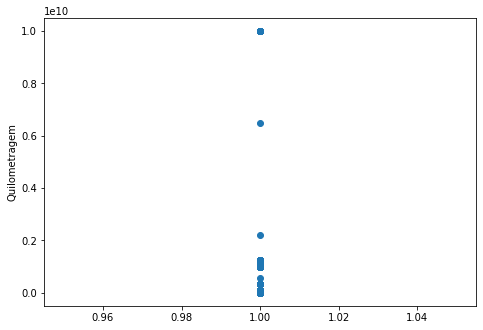

In [52]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter([1]*len(df['Quilometragem']), df['Quilometragem'])
ax.set_ylabel('Quilometragem')
# ax.set_yscale('log')

<AxesSubplot:ylabel='Frequency'>

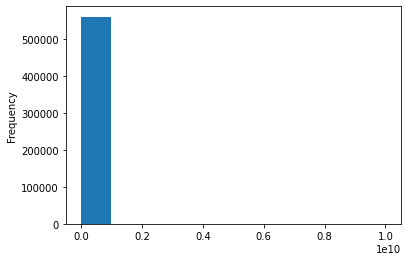

In [53]:
df['Quilometragem'].plot.hist(bins=20)

Existem outliers acima de 300000 km e também existem erros em quilometragens muito baixas como quilometragens que são abaixo de 5000. A baixa quilometragem se refere a anúncios em que a pessoa ao invés de digitar a casa dos milhares, digita apenas o número, por exemplo, para representar 130000km, a pessoa colocar apenas 130. Isso prejudicaria os modelos futuros de machine learning, portanto também serão removidos do dataset. O dataset conterá então apenas carros usados com quilometragem entre 5000km e 300000km.

In [60]:
df = df[df['Quilometragem'] >= 5000]
df = df[df['Quilometragem'] <= 300000]
df

,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Combustível,Câmbio,Portas,Final de placa,CEP,Município,Bairro,url,Potência do motor,Direção,Cor
0,VW - VOLKSWAGEN POLO HIGHLINE 200 TSI 1.0 FLEX...,VW - VOLKSWAGEN,Passeio,2019.0,46600.0,Flex,Automático,4.0,8.0,36080262.0,Juiz de Fora,São Dimas,https://mg.olx.com.br/regiao-de-juiz-de-fora/a...,NaN,NaN,NaN
1,RENAULT CLIO AUTHENTIQUE HI-FLEX 1.0 16V 5P,RENAULT,Sedã,2005.0,100010.0,Flex,Manual,4.0,NaN,65632700.0,Timon,Sete Estrelas,https://ma.olx.com.br/regiao-de-imperatriz-e-c...,1.0,NaN,NaN
3,FORD FOCUS 1.6 S/SE/SE PLUS FLEX 8V/16V 5P,FORD,Hatch,2009.0,145000.0,Flex,Manual,4.0,7.0,17014340.0,Bauru,Vila Mesquita,https://sp.olx.com.br/regiao-de-bauru-e-marili...,1.6,Hidráulica,Preto
4,HONDA CIVIC SEDAN LXS 1.8/1.8 FLEX 16V AUT. 4P,HONDA,Sedã,2008.0,162000.0,Flex,Automático,4.0,7.0,85525000.0,Mariópolis,NaN,https://pr.olx.com.br/regiao-de-francisco-belt...,1.8,Hidráulica,Preto
5,GM - CHEVROLET SPIN ACTIV7 1.8 8V ECONO.FLEX 5...,GM - CHEVROLET,Passeio,2020.0,45000.0,Flex,Automático,4.0,1.0,22775005.0,Rio de Janeiro,Jacarepaguá,https://rj.olx.com.br/rio-de-janeiro-e-regiao/...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,HYUNDAI ELANTRA GLS 2.0 16V FLEX AUT.,HYUNDAI,Sedã,2015.0,79600.0,Flex,Automático,4.0,2.0,70773000.0,Brasília,Asa Norte,https://df.olx.com.br/distrito-federal-e-regia...,2.0 - 2.9,Elétrica,Branco
4994,PEUGEOT 2008 GRIFE 1.6 TURBO FLEX 16V 5P AUT,PEUGEOT,SUV,2020.0,12000.0,Flex,Automático,4.0,7.0,69020130.0,Manaus,Praça 14 de Janeiro,https://am.olx.com.br/regiao-de-manaus/autos-e...,1.6,Elétrica,Branco
4997,VW - VOLKSWAGEN POLO HIGHLINE 200 TSI 1.0 FLEX...,VW - VOLKSWAGEN,Passeio,2020.0,17900.0,Flex,Automático,NaN,2.0,74471150.0,Goiânia,Fazenda Caveiras - Residencial Bosque dos Buritis,https://go.olx.com.br/grande-goiania-e-anapoli...,1.0,Hidráulica,Prata
4998,HONDA CIVIC SEDAN EX 2.0 FLEX 16V AUT.4P,HONDA,Sedã,2018.0,44200.0,Flex,Automático,4.0,1.0,29050535.0,Vitória,Enseada do Suá,https://es.olx.com.br/norte-do-espirito-santo/...,2.0 - 2.9,Hidráulica,Cinza


<AxesSubplot:ylabel='Frequency'>

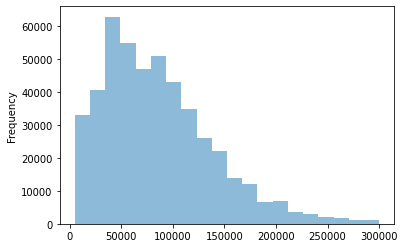

In [65]:
df['Quilometragem'].plot.hist(bins=20, alpha=0.5)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 467254 entries, 0 to 5000
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Modelo             467254 non-null  object 
 1   Marca              465277 non-null  object 
 2   Tipo de veículo    405376 non-null  object 
 3   Ano                467254 non-null  object 
 4   Quilometragem      467254 non-null  float64
 5   Combustível        455832 non-null  object 
 6   Câmbio             457842 non-null  object 
 7   Portas             448008 non-null  float64
 8   Final de placa     407321 non-null  float64
 9   CEP                467254 non-null  float64
 10  Município          467254 non-null  object 
 11  Bairro             423045 non-null  object 
 12  url                467254 non-null  object 
 13  Potência do motor  384725 non-null  object 
 14  Direção            394876 non-null  object 
 15  Cor                409465 non-null  object 
dtypes: f

In [68]:
df.describe()

,Quilometragem,Portas,Final de placa,CEP
count,467254.000000,448008.000000,407321.000000,4.672540e+05
mean,85663.201056,3.798329,4.372711,4.602972e+07
std,53474.416592,0.602222,2.982578,2.963030e+07
min,5001.000000,2.000000,0.000000,1.001000e+06
25%,45000.000000,4.000000,2.000000,1.803500e+07
50%,77400.000000,4.000000,4.000000,4.150070e+07
75%,115000.000000,4.000000,7.000000,7.407003e+07
max,299999.000000,4.000000,9.000000,9.995000e+07


In [67]:
df.to_csv('cars_dataset.csv', index=False)